In [28]:
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

import pickle
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
color = sns.color_palette()
sns.set_style('darkgrid')
sns.set_context('notebook')

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [3]:
# load pre-processed data
train_df, test_df, test_df_truncated, solution_df_truncated, desired_class, desired_ID, X_train_array, X_test_array = pickle.load( open( "cleaned_train.pkl", "rb" ) )


In [9]:
# 1. Transform categorical labels to numerical labels between 0 and len(labels) using labelEncoder
# 2. one hot encode our label
y_train = train_df.Class
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train_hot = np_utils.to_categorical(label_encoder.transform(y_train))

# target labels
y_true = [int(x) for x in desired_class.ravel()]
y_true_oh = solution_df_truncated.values

In [4]:
# put everything together into a function
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true,y_pred,title='ROC title'):
    # calculate ROC in a one-vs-all manner
    # y_true needs to be binary (one-hot encoded)
    # y_pred needs to be probabilities
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    num_classes = y_true.shape[1]

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i],y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot of a ROC curve for a specific class
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label='Class %i (area = %0.2f)' %(i+1,roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

C:\Users\Kenny\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


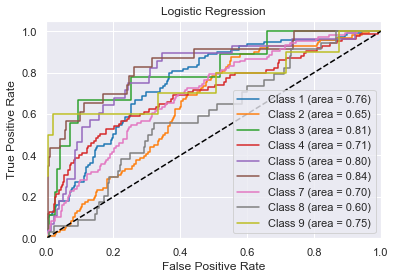

C:\Users\Kenny\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


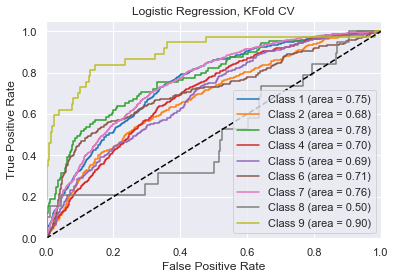

In [37]:
# logistic regression
model = LogisticRegression()
model.fit(X_train_array,y_train)
y_pred = model.predict_proba(X_test_array)
auc_logit = plot_roc(y_true_oh, y_pred,'Logistic Regression')

y_pred = cross_val_predict(model, X_train_array, y_train, cv=StratifiedKFold(random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
auc_logit = plot_roc(y_train_hot, y_pred,'Logistic Regression, KFold CV')

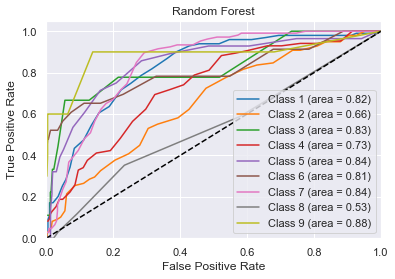

In [34]:
# model built on training data and evaluated on test data
# RFC
model = RandomForestClassifier()
model.fit(X_train_array,y_train)
y_pred = model.predict_proba(X_test_array)
auc_logit = plot_roc(y_true_oh, y_pred,'Random Forest')

C:\Users\Kenny\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.9s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


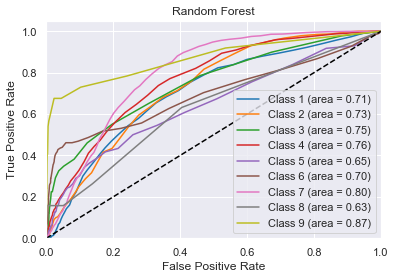

In [35]:
# model built on training data w/ k-fold cross validation, evaluated on training data
y_pred = cross_val_predict(model, X_train_array, y_train, cv=StratifiedKFold(random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
auc_logit = plot_roc(y_train_hot, y_pred,'Random Forest')

In [32]:
probas.shape

(3316, 9)

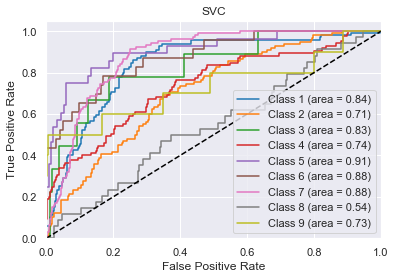

C:\Users\Kenny\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.0s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.2s finished


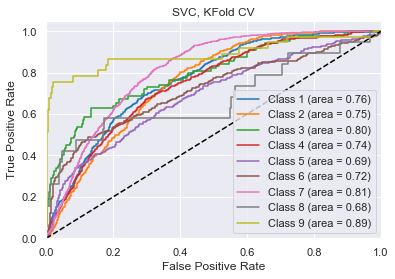

In [36]:
# SVC
model = SVC(kernel='rbf',gamma='auto',probability=True)
model.fit(X_train_array,y_train)
y_pred = model.predict_proba(X_test_array)
auc_logit = plot_roc(y_true_oh, y_pred,'SVC')

y_pred = cross_val_predict(model, X_train_array, y_train, cv=StratifiedKFold(random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
auc_logit = plot_roc(y_train_hot, y_pred,'SVC, KFold CV')